## Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from datetime import datetime, timedelta
import yfinance as yf
import os
import sys

In [3]:
sys.path.append(os.path.abspath('../src/'))

In [4]:
from preprocess import data_loader

### Step 1: Load and Preprocess Data

In [5]:

df = data_loader('../data/processed/clean_close_prices_for_analysis.csv')
print("CSV Head:\n", df.head())

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.set_index('Date')
tsla_close = df['TSLA_Close'].asfreq('B').fillna(method='ffill')

CSV Head:
          Date  BND_Close   SPY_Close  TSLA_Close
0  2015-07-01  60.816738  174.917084   17.943333
1  2015-07-02  60.967102  174.756943   18.667999
2  2015-07-03  61.019717  174.632603   18.663000
3  2015-07-06  61.177563  174.259583   18.648001
4  2015-07-07  61.237713  175.355423   17.858667


C:\Users\ASTU-PG\AppData\Local\Temp\ipykernel_10296\1541944293.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tsla_close = df['TSLA_Close'].asfreq('B').fillna(method='ffill')


#### Split Data: Train (2015-2023), Test (2024-2025)

In [6]:
# Split Data: Train (2015-2023), Test (2024-2025)
train_end = '2023-12-31'
test_start = '2024-01-01'
train = tsla_close.loc[:train_end]
test = tsla_close.loc[test_start:datetime.now().strftime('%Y-%m-%d')]
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (2218,), Test shape: (413,)


### Step 2: Prepare LSTM Model and Data

In [7]:
from forecast import create_sequences, TimeSeriesDataset, LSTMModel

In [8]:
# Step 2: Prepare LSTM Model and Data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

seq_length = 90
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(np.concatenate((train_scaled[-seq_length:], test_scaled)), seq_length)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)

train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = LSTMModel(dropout=0.2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Train LSTM
for epoch in range(200):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

c:\Users\ASTU-PG\TSForecasting4Portfolio_Management_Optimization\.tsenv\Lib\site-packages\torch\nn\modules\loss.py:616: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\ASTU-PG\TSForecasting4Portfolio_Management_Optimization\.tsenv\Lib\site-packages\torch\nn\modules\loss.py:616: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.1037
Epoch 10, Loss: 0.0883
Epoch 20, Loss: 0.0717
Epoch 30, Loss: 0.0665
Epoch 40, Loss: 0.1209
Epoch 50, Loss: 0.0515
Epoch 60, Loss: 0.1119
Epoch 70, Loss: 0.0677
Epoch 80, Loss: 0.0667
Epoch 90, Loss: 0.0605
Epoch 100, Loss: 0.0820
Epoch 110, Loss: 0.1150
Epoch 120, Loss: 0.0948
Epoch 130, Loss: 0.0841
Epoch 140, Loss: 0.0904
Epoch 150, Loss: 0.0879
Epoch 160, Loss: 0.0591
Epoch 170, Loss: 0.0705
Epoch 180, Loss: 0.0632
Epoch 190, Loss: 0.0717


### Step 3: Generate Forecast for 6-12 Months

In [9]:
# Step 3: Generate Forecast for 6-12 Months
forecast_days = 252  # ~12 months of business days
last_sequence = torch.FloatTensor(test_scaled[-seq_length:]).unsqueeze(0)  # [1, 60, 1]

model.eval()
forecast_scaled = []
with torch.no_grad():
    for _ in range(forecast_days):
        next_pred = model(last_sequence)
        forecast_scaled.append(next_pred.numpy()[0, 0])
        # Fix: Ensure next_pred has the same number of dimensions as last_sequence[:, 1:, :]
        next_pred_3d = next_pred.unsqueeze(1)  # [1, 1] -> [1, 1, 1]
        last_sequence = torch.cat((last_sequence[:, 1:, :], next_pred_3d), dim=1)  # Concatenate along time

forecast_scaled = np.array(forecast_scaled)
forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1))
forecast_index = pd.date_range(start=test.index[-1] + timedelta(days=1), periods=forecast_days, freq='B')
forecast_series = pd.Series(forecast.flatten(), index=forecast_index)

### Step 4: Monte Carlo for Confidence Intervals

In [11]:
n_simulations = 100
simulations = []
torch.manual_seed(42)  # For reproducibility
with torch.no_grad():
    for _ in range(n_simulations):
        sim_sequence = torch.FloatTensor(test_scaled[-seq_length:]).unsqueeze(0)  # [1, 60, 1]
        sim_forecast = []
        for _ in range(forecast_days):
            pred = model(sim_sequence)
            sim_forecast.append(pred.numpy()[0, 0])
            # Add noise based on test set RMSE (16.36 from Task 2)
            noise = np.random.normal(0, 16.36 / scaler.scale_[0])  # Scale to original units
            next_input = pred + torch.FloatTensor([noise]).unsqueeze(1).unsqueeze(1)  # [1, 1] -> [1, 1, 1]
            sim_sequence = torch.cat((sim_sequence[:, 1:, :], next_input), dim=1)  # Concatenate along time
        simulations.append(sim_forecast)

simulations = np.array(simulations)
lower_ci = scaler.inverse_transform(np.percentile(simulations, 2.5, axis=0).reshape(-1, 1))
upper_ci = scaler.inverse_transform(np.percentile(simulations, 97.5, axis=0).reshape(-1, 1))

### Step 5: Visualize Forecast

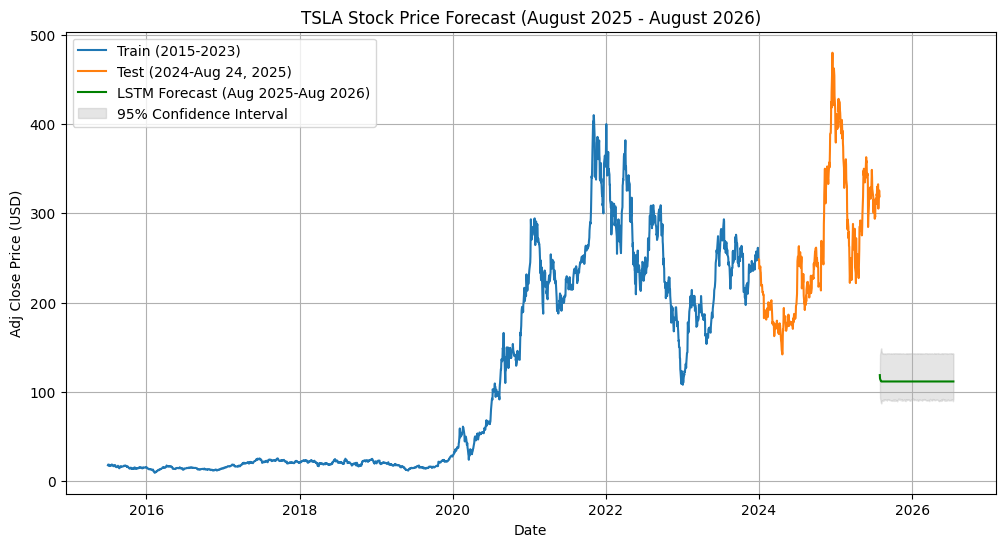

In [12]:
# Step 5: Visualize Forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train (2015-2023)')
plt.plot(test.index, test, label='Test (2024-Aug 24, 2025)')
plt.plot(forecast_series.index, forecast_series, label='LSTM Forecast (Aug 2025-Aug 2026)', color='green')
plt.fill_between(forecast_series.index, lower_ci.flatten(), upper_ci.flatten(), color='gray', alpha=0.2, label='95% Confidence Interval')
plt.title('TSLA Stock Price Forecast (August 2025 - August 2026)')
plt.xlabel('Date')
plt.ylabel('Adj Close Price (USD)')
plt.legend()
plt.grid()
plt.show()


### Step 6: Save Forecast Data (for analysis)

In [13]:
# Step 6: Save Forecast Data
forecast_data = pd.DataFrame({
    'Date': forecast_series.index,
    'Forecast_Price': forecast_series.values,
    'Lower_CI': lower_ci.flatten(),
    'Upper_CI': upper_ci.flatten()
})
forecast_data.to_csv('../data/processed/tsla_forecast_2025_2026.csv', index=False)
print("Forecast data saved to '../data/processed/tsla_forecast_2025_2026.csv'")


Forecast data saved to '../data/processed/tsla_forecast_2025_2026.csv'
